# Build the Neural Network and denormalized the metrics
### Change the read_csv to change between the original dataset and reduced datasets

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#df = pd.read_csv("data.csv")
df = pd.read_csv("data-filtered.csv")
df = df.sample(frac=1)
df.shape

(506763, 21)

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Split features and target variables
X = df.iloc[:, :(df.shape[1]-5)].values
Y = df.iloc[:, (df.shape[1]-5):].values

# Normalize input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Normalize target variables
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)
X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

# Create DataLoader for batched training data
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [ ]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.fc1 = nn.Linear((df.shape[1]-5), 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        #self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(32, 5)
        #self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        #x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


Epoch [5/50], Train Loss: 0.3449, Validation Loss: 0.3500
Epoch [10/50], Train Loss: 0.3490, Validation Loss: 0.3473
Epoch [15/50], Train Loss: 0.3387, Validation Loss: 0.3466
Epoch [20/50], Train Loss: 0.3498, Validation Loss: 0.3456
Epoch [25/50], Train Loss: 0.3319, Validation Loss: 0.3453
Epoch [30/50], Train Loss: 0.3581, Validation Loss: 0.3450
Epoch [35/50], Train Loss: 0.3211, Validation Loss: 0.3448
Epoch [40/50], Train Loss: 0.3648, Validation Loss: 0.3449
Epoch [45/50], Train Loss: 0.3484, Validation Loss: 0.3448
Epoch [50/50], Train Loss: 0.3454, Validation Loss: 0.3448


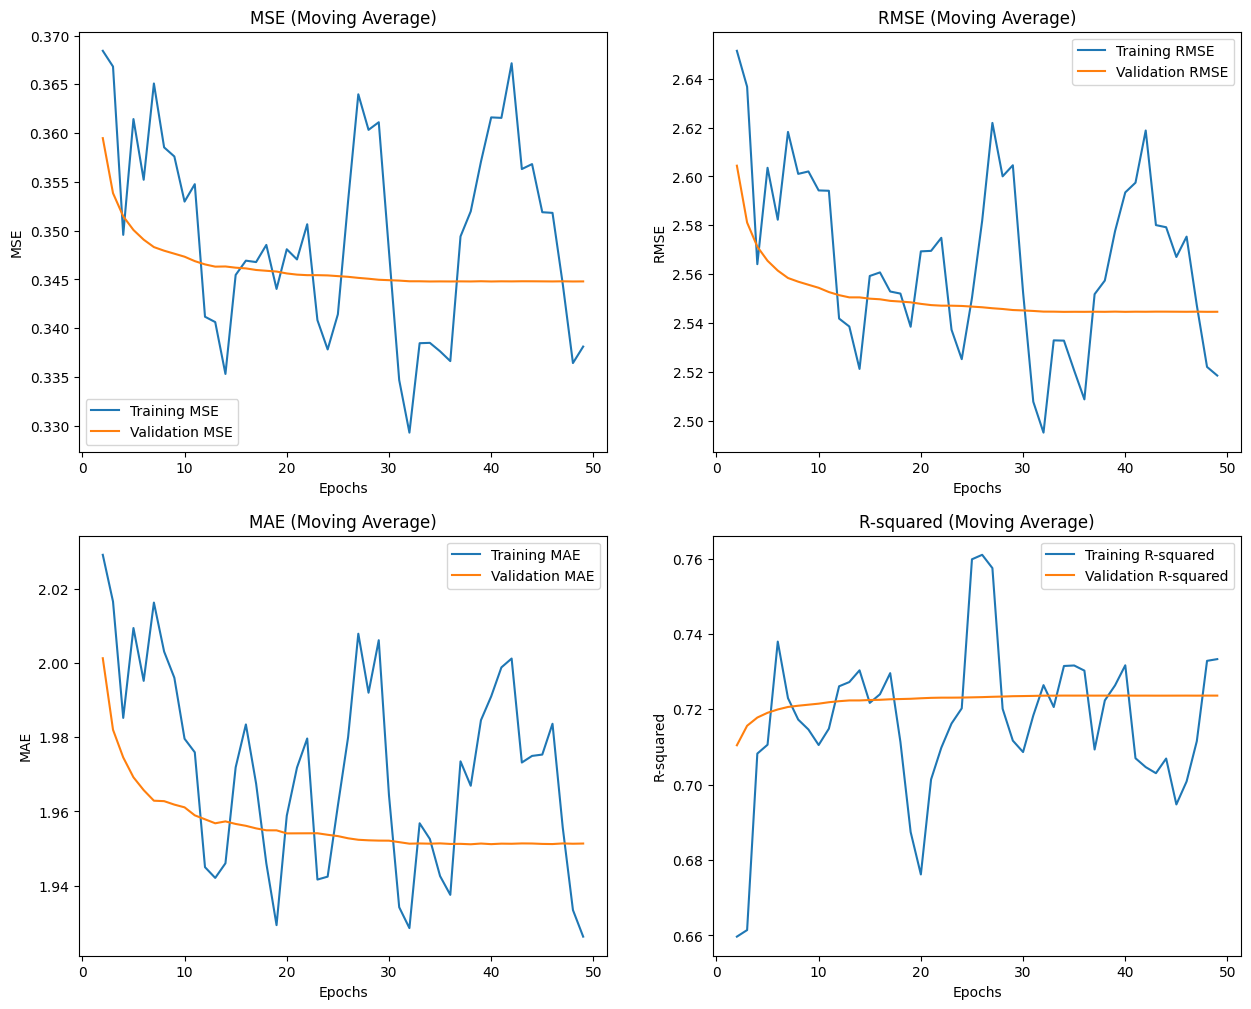

In [ ]:
# Create the improved model
improved_model = ImprovedNet()

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(improved_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
train_rmse = []
val_rmse = []
train_mae = []
val_mae = []
train_r2 = []
val_r2 = []


def r_squared(y_true, y_pred):
    residual_sum_of_squares = torch.sum((y_true - y_pred) ** 2)
    total_sum_of_squares = torch.sum((y_true - torch.mean(y_true)) ** 2)
    return 1 - residual_sum_of_squares / total_sum_of_squares


for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = improved_model(inputs)
        loss = criterion(outputs, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    # Denormalize training outputs and targets
    original_scale_outputs = scaler_y.inverse_transform(outputs.detach().numpy())
    original_scale_targets = scaler_y.inverse_transform(targets.detach().numpy())

    # Compute validation outputs
    val_outputs = improved_model(X_test)
    val_loss = criterion(val_outputs, Y_test)

    # Denormalize validation outputs and Y_test
    original_scale_val_outputs = scaler_y.inverse_transform(val_outputs.detach().numpy())
    original_scale_Y_test = scaler_y.inverse_transform(Y_test.detach().numpy())

    # Append losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Calculate RMSE, MAE, and Rsquare using denormalized data for both training and validation
    train_r2_score = r_squared(torch.Tensor(original_scale_targets), torch.Tensor(original_scale_outputs))
    val_r2_score = r_squared(torch.Tensor(original_scale_Y_test), torch.Tensor(original_scale_val_outputs))
    train_rmse_score = torch.sqrt(criterion(torch.Tensor(original_scale_outputs), torch.Tensor(original_scale_targets)))
    val_rmse_score = torch.sqrt(criterion(torch.Tensor(original_scale_val_outputs), torch.Tensor(original_scale_Y_test)))
    train_mae_score = torch.mean(torch.abs(torch.Tensor(original_scale_outputs) - torch.Tensor(original_scale_targets)))
    val_mae_score = torch.mean(torch.abs(torch.Tensor(original_scale_val_outputs) - torch.Tensor(original_scale_Y_test)))

    # Append the metrics
    train_r2.append(train_r2_score.item())
    val_r2.append(val_r2_score.item())
    train_rmse.append(train_rmse_score.item())
    val_rmse.append(val_rmse_score.item())
    train_mae.append(train_mae_score.item())
    val_mae.append(val_mae_score.item())



    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Function to calculate the moving average
def moving_average(values, window):
    """Calculate the moving average given a list of values and a window size."""
    weights = np.ones(window) / window
    return np.convolve(values, weights, mode='valid')

# Calculate the moving average for the losses and metrics
window_size = 3
smoothed_train_losses = moving_average(train_losses, window_size)
smoothed_val_losses = moving_average(val_losses, window_size)
smoothed_train_rmse = moving_average(train_rmse, window_size)
smoothed_val_rmse = moving_average(val_rmse, window_size)
smoothed_train_mae = moving_average(train_mae, window_size)
smoothed_val_mae = moving_average(val_mae, window_size)
smoothed_train_r2 = moving_average(train_r2, window_size)
smoothed_val_r2 = moving_average(val_r2, window_size)

# Adjust the range for the x-axis to account for the reduced length after moving average
epochs_range = range(window_size - 1, num_epochs)

# Plot training and validation losses, RMSE, MAE, and MSE with moving average
plt.figure(figsize=(15, 12))

# MSE plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range, smoothed_train_losses, label='Training MSE')
plt.plot(epochs_range, smoothed_val_losses, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE (Moving Average)')

# RMSE plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range, smoothed_train_rmse, label='Training RMSE')
plt.plot(epochs_range, smoothed_val_rmse, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE (Moving Average)')

# MAE plot
plt.subplot(2, 2, 3)
plt.plot(epochs_range, smoothed_train_mae, label='Training MAE')
plt.plot(epochs_range, smoothed_val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE (Moving Average)')

# R-squared plot
plt.subplot(2, 2, 4)
plt.plot(epochs_range, smoothed_train_r2, label='Training R-squared')
plt.plot(epochs_range, smoothed_val_r2, label='Validation R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.legend()
plt.title('R-squared (Moving Average)')

plt.show()



In [ ]:
print(smoothed_val_losses[-1])
print(smoothed_val_rmse[-1])
print(smoothed_val_mae[-1])
print(smoothed_val_r2[-1])

0.34480130672454834
2.5445488293965655
1.9513325691223145
0.7236537138621012
